In [634]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score, r2_score,roc_auc_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import catboost as cb
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

from matplotlib import pyplot as plt

In [635]:
filepath = "properties_data_set_19_11_20H00.csv"
income_data = "/Users/irisvirus/Desktop/Becode/Python/Projects/Regression/regression/INCOME DATA 2022.csv"
poverty_data = "/Users/irisvirus/Desktop/Becode/Python/Projects/Regression/regression/POVERTY RISK DATA.csv"
zipcode = "/Users/irisvirus/Desktop/Becode/Python/Projects/Regression/regression/BELGIUM/zipcodes_num_nl_new_Tumi.xls"
id = pd.read_csv(income_data)
povd = pd.read_csv(poverty_data)
df = pd.read_csv(filepath)
zcode = pd.read_excel(zipcode)
df.set_index("house_index",drop=True, inplace=True )

In [636]:
#Clean Income Data
id_new_header = ["Locality", "min_median_income", "unnamed", "max_median_income", "locality"]
id.columns = id_new_header
id = id.drop(columns=["Locality", "unnamed"])

In [637]:
id.head()

,min_median_income,max_median_income,locality
0,23.986,51.2609 4.3695,Antwerp
1,30.579,51.1605 4.5105,Boechout
2,25.936,51.0937 4.3731,Boom
3,26.591,51.1915 4.488,Borsbeek
4,29.869,51.31 4.4995,Brasschaat


In [638]:
id.shape

(579, 3)

In [639]:
#rename columns from bpPost
zcode = zcode.rename(columns={'Localité': 'locality'})

In [640]:
zcode.head()

,Postcode,NAME,SUBMUNICIPALITY,MAIN MUNICIPALITY,Provincie
0,2040,Berendrecht,Ja,ANTWERPEN,ANTWERPEN
1,2040,Lillo,Ja,ANTWERPEN,ANTWERPEN
2,2040,Zandvliet,Ja,ANTWERPEN,ANTWERPEN
3,2070,Burcht,Ja,ZWIJNDRECHT,ANTWERPEN
4,2100,Deurne,Ja,ANTWERPEN,ANTWERPEN


In [641]:
zcode.rename(columns={'Postcode': 'postal_code', 'Provincie': 'province','NAME':'locality','MAIN MUNICIPALITY':"municipality"}, inplace=True)


In [642]:
zcode.head()

,postal_code,locality,SUBMUNICIPALITY,municipality,province
0,2040,Berendrecht,Ja,ANTWERPEN,ANTWERPEN
1,2040,Lillo,Ja,ANTWERPEN,ANTWERPEN
2,2040,Zandvliet,Ja,ANTWERPEN,ANTWERPEN
3,2070,Burcht,Ja,ZWIJNDRECHT,ANTWERPEN
4,2100,Deurne,Ja,ANTWERPEN,ANTWERPEN


In [643]:
zcode

,postal_code,locality,SUBMUNICIPALITY,municipality,province
0,2040,Berendrecht,Ja,ANTWERPEN,ANTWERPEN
1,2040,Lillo,Ja,ANTWERPEN,ANTWERPEN
2,2040,Zandvliet,Ja,ANTWERPEN,ANTWERPEN
3,2070,Burcht,Ja,ZWIJNDRECHT,ANTWERPEN
4,2100,Deurne,Ja,ANTWERPEN,ANTWERPEN
...,...,...,...,...,...
2716,8930,Menen,Neen,MENEN,WEST-VLAANDEREN
2717,8940,Wervik,Neen,WERVIK,WEST-VLAANDEREN
2718,8957,Mesen,Neen,MESEN,WEST-VLAANDEREN
2719,8970,Poperinge,Neen,POPERINGE,WEST-VLAANDEREN


In [644]:
id["postal_code"] = None
id["province"] = None

In [645]:
zcode.province = zcode["province"].astype(str)
zcode.locality = zcode["locality"].astype(str)
zcode.municipality = zcode["municipality"].astype(str)
zcode.province = zcode.province.apply(lambda x: x.strip().lower())
zcode.locality = zcode.locality.apply(lambda x: x.strip().lower())
zcode.municipality = zcode.municipality.apply(lambda x: x.strip().lower())
id.locality = id.locality.apply(lambda x: x.strip().lower())
id.locality = id["locality"].astype(str)

In [646]:
zcode.head()

,postal_code,locality,SUBMUNICIPALITY,municipality,province
0,2040,berendrecht,Ja,antwerpen,antwerpen
1,2040,lillo,Ja,antwerpen,antwerpen
2,2040,zandvliet,Ja,antwerpen,antwerpen
3,2070,burcht,Ja,zwijndrecht,antwerpen
4,2100,deurne,Ja,antwerpen,antwerpen


In [647]:
id.columns

Index(['min_median_income', 'max_median_income', 'locality', 'postal_code',
       'province'],
      dtype='object')

In [648]:
id.rename(columns={'max_median_income': 'gps_coordinates', "min_median_income" : "median_income"}, inplace=True)
id

,median_income,gps_coordinates,locality,postal_code,province
0,23.986,51.2609 4.3695,antwerp,None,None
1,30.579,51.1605 4.5105,boechout,None,None
2,25.936,51.0937 4.3731,boom,None,None
3,26.591,51.1915 4.488,borsbeek,None,None
4,29.869,51.31 4.4995,brasschaat,None,None
...,...,...,...,...,...
574,25.033,50.151 4.759,doische,None,None
575,26.334,50.2605 4.5675,florennes,None,None
576,25.695,50.161 4.546,philippeville,None,None
577,27.975,50.2725 4.4555,walcourt,None,None


In [649]:
id[['latitude', 'longitude']] = id['gps_coordinates'].str.split(expand=True).astype(float)

In [650]:
id = id.drop(columns="gps_coordinates")

In [651]:
id

,median_income,locality,postal_code,province,latitude,longitude
0,23.986,antwerp,None,None,51.2609,4.3695
1,30.579,boechout,None,None,51.1605,4.5105
2,25.936,boom,None,None,51.0937,4.3731
3,26.591,borsbeek,None,None,51.1915,4.4880
4,29.869,brasschaat,None,None,51.3100,4.4995
...,...,...,...,...,...,...
574,25.033,doische,None,None,50.1510,4.7590
575,26.334,florennes,None,None,50.2605,4.5675
576,25.695,philippeville,None,None,50.1610,4.5460
577,27.975,walcourt,None,None,50.2725,4.4555


In [652]:
for index, row in id.iterrows():
    # Normalize the 'locality' column in both DataFrames
    id_locality = row['locality'].strip().lower() if isinstance(row['locality'], str) else ''
    zcode['normalized_locality'] = zcode['locality'].apply(lambda x: x.strip().lower() if isinstance(x, str) else '')
    
    # Find matching rows based on normalized 'locality'
    matching_row = zcode[zcode['normalized_locality'] == id_locality]


    
    if not matching_row.empty:
        # Copy relevant data from matching_row to id
        id.at[index, 'postal_code'] = matching_row['postal_code'].values[0]
        id.at[index, 'province'] = matching_row['province'].values[0]
        id.at[index, 'new_column'] = 'Match Found'
    else:
        # Add a flag if no match is found
        id.at[index, 'new_column'] = 'No Match'

print(id)


     median_income       locality postal_code   province  latitude  longitude  \
0           23.986        antwerp        None       None   51.2609     4.3695   
1           30.579       boechout        2530  antwerpen   51.1605     4.5105   
2           25.936           boom        2850  antwerpen   51.0937     4.3731   
3           26.591       borsbeek        2150  antwerpen   51.1915     4.4880   
4           29.869     brasschaat        2930  antwerpen   51.3100     4.4995   
..             ...            ...         ...        ...       ...        ...   
574         25.033        doische        5680      namen   50.1510     4.7590   
575         26.334      florennes        5620      namen   50.2605     4.5675   
576         25.695  philippeville        5600      namen   50.1610     4.5460   
577         27.975       walcourt        5650      namen   50.2725     4.4555   
578         23.930      viroinval        None       None   50.0500     4.6240   

      new_column  
0       

In [653]:
df.locality
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16111 entries, 0 to 19978
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          16111 non-null  int64  
 1   property_type     16111 non-null  object 
 2   property_subtype  16111 non-null  object 
 3   locality          16111 non-null  object 
 4   postal_code       16111 non-null  int64  
 5   street            15697 non-null  object 
 6   number            15596 non-null  object 
 7   box               5027 non-null   object 
 8   kitchen           16111 non-null  int64  
 9   facades           11576 non-null  float64
 10  price             16110 non-null  float64
 11  furnished         16111 non-null  int64  
 12  terrace           16111 non-null  int64  
 13  terraceSurface    11339 non-null  float64
 14  fireplace         16111 non-null  int64  
 15  fireplaceCount    16111 non-null  int64  
 16  buildingState     13388 non-null  object 
 17

In [654]:
# Merge datasets on locality
merged_df = id.merge(zcode, on=['locality','postal_code'], how='left')
id.head(20)


,median_income,locality,postal_code,province,latitude,longitude,new_column
0,23.986,antwerp,None,None,51.2609,4.3695,No Match
1,30.579,boechout,2530,antwerpen,51.1605,4.5105,Match Found
2,25.936,boom,2850,antwerpen,51.0937,4.3731,Match Found
3,26.591,borsbeek,2150,antwerpen,51.1915,4.4880,Match Found
4,29.869,brasschaat,2930,antwerpen,51.3100,4.4995,Match Found
5,30.339,brecht,2960,antwerpen,51.3290,4.5940,Match Found
6,30.055,edegem,2650,antwerpen,51.1590,4.4305,Match Found
7,28.732,essen,2910,antwerpen,51.4485,4.4635,Match Found
8,28.673,hemiksem,2620,antwerpen,51.1455,4.3405,Match Found
9,32.455,hove,2540,antwerpen,51.1474,4.4820,Match Found


In [655]:
id.loc[0, 'province'] = 'antwerp'
id.loc[0, 'postal_code'] = 2000
id.loc[0]

median_income      23.986
locality          antwerp
postal_code          2000
province          antwerp
latitude          51.2609
longitude          4.3695
new_column       No Match
Name: 0, dtype: object

In [656]:
id.postal_code.isna().sum()

101

In [657]:
id = id.fillna(value=np.nan)

/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_19945/1019745166.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  id = id.fillna(value=np.nan)


In [658]:
id['postal_code'] = pd.to_numeric(id['postal_code'], errors='coerce').fillna(0).astype(int)


In [659]:
id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   median_income  579 non-null    float64
 1   locality       579 non-null    object 
 2   postal_code    579 non-null    int64  
 3   province       478 non-null    object 
 4   latitude       579 non-null    float64
 5   longitude      579 non-null    float64
 6   new_column     579 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 31.8+ KB


In [660]:
missing_rows = id[id["postal_code"].isna()].index
print(missing_rows)


Index([], dtype='int64')


In [661]:
id.isna().sum()

median_income      0
locality           0
postal_code        0
province         101
latitude           0
longitude          0
new_column         0
dtype: int64

In [662]:
municipalities = id["locality"].unique().tolist()
print((municipalities))

['antwerp', 'boechout', 'boom', 'borsbeek', 'brasschaat', 'brecht', 'edegem', 'essen', 'hemiksem', 'hove', 'kalmthout', 'kapellen', 'kontich', 'lint', 'mortsel', 'niel', 'ranst', 'rumst', 'schelle', 'schilde', 'schoten', 'stabroek', 'wijnegem', 'wommelgem', 'wuustwezel', 'zandhoven', 'zoersel', 'zwijndrecht', 'malle', 'berlaar', 'bonheiden', 'bornem', 'duffel', 'heist-op-den-berg', 'lier', 'mechelen', 'nijlen', 'putte', 'sint-katelijne-waver', 'willebroek', 'puurs-sint-amands', 'arendonk', 'baarle-hertog', 'balen', 'beerse', 'dessel', 'geel', 'grobbendonk', 'herentals', 'herenthout', 'herselt', 'hoogstraten', 'hulshout', 'kasterlee', 'lille', 'meerhout', 'merksplas', 'mol', 'olen', 'oud-turnhout', 'ravels', 'retie', 'rijkevorsel', 'turnhout', 'vorselaar', 'vosselaar', 'westerlo', 'laakdal', 'anderlecht', 'oudergem', 'sint-agatha-berchem', 'brussels', 'etterbeek', 'evere', 'vorst', 'ganshoren', 'elsene', 'jette', 'koekelberg', 'sint-jans-molenbeek', 'sint-gillis', 'sint-joost-ten-node',

In [663]:
locality_count = (df.groupby("locality")["locality"].agg("count")).sort_values(ascending=False)
locality_count



locality
Knokke-Heist                  542
Antwerpen                     367
Oostende                      340
Gent                          285
Knokke                        276
                             ... 
COUTHUIN                        1
CUESMES                         1
Marchienne-au-Pont              1
Marche-en-Famenne, Marloie      1
‘s Gravenwezel Schilde          1
Name: locality, Length: 2261, dtype: int64

In [664]:
len(locality_count[locality_count<10])

1915

In [665]:
df.shape

(16111, 25)

In [666]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from scipy import stats


#Additional data cleaning and renaming
df = df[df['price'] >= 40000]
df = df[df['bedrooms'] <= 9]
df['house_index'] = range(1, len(df) + 1)

df['buildingState'] = df['buildingState'].replace({
    'AS_NEW': 1,
    'JUST_RENOVATED': 2,
    'GOOD': 3,
    'TO_RESTORE': 4,
    'TO_RENOVATE': 4,
    'TO_BE_DONE_UP':4
})


#print(df['buildingState'].nunique())
#print(df['buildingState'].unique())


df['province'] = df['province'].replace({'flemish_brabant_extended': 'flemish_brabant', 'hainaut_extended': 'hainaut_province'})
df['province'] = df['province'].replace({'flemish_brabant': 'Flemish Brabant', 'hainaut_province': 'Hainaut', 'antwerp_province': 'Antwerp', 'brussels_capital': 'Brussels', 
                                         'limburg_province': 'Limburg', 'liège_province': 'Liège', 'luxembourg_province': 'Luxembourg', 'namur_province': 'Namur', 
                                         'walloon_brabant': 'Walloon Brabant', 'west_flanders': 'West Flanders','east_flanders': 'East Flanders'})
#print(df['province'].nunique())
#print(df['province'].unique())


#Number of rows and columns and useless columns dropped
rows, columns = df.shape
table = PrettyTable()
table.field_names = ["Axis", "Count"]
table.add_row(["Number of Rows", rows])
table.add_row(["Number of Columns", columns])
print(table)
df = df.drop(['street', 'number', 'box', 'landSurface', 'fireplaceCount'], axis=1)

#NaN counts before changes
nan_count = df.isna().sum()
total_rows = len(df)
table = PrettyTable()
table.field_names = ["Column Name", "NaN Count", "NaN Percentage"]
for column_name in nan_count.index:
    nan_percentage = (nan_count[column_name] / total_rows) * 100
    table.add_row([column_name, nan_count[column_name], f"{nan_percentage:.2f}%"])
print(table)

#Cleaning
columns_to_replace = ['terraceSurface']
df[columns_to_replace] = df[columns_to_replace].fillna(0)
df = df.dropna(subset=['livingArea'])
df = df.drop(['property_subtype', 'typeOfSale', 'terrace', 'garden'], axis=1)

#Summary after changes
rows, columns = df.shape
table = PrettyTable()
table.field_names = ["Axis", "Count"]
table.add_row(["Number of Rows", rows])
table.add_row(["Number of Columns", columns])
print(table)

nan_count = df.isna().sum()
total_rows = len(df)
table = PrettyTable()
table.field_names = ["Column Name", "NaN Count", "NaN Percentage"]
for column_name in nan_count.index:
    nan_percentage = (nan_count[column_name] / total_rows) * 100
    table.add_row([column_name, nan_count[column_name], f"{nan_percentage:.2f}%"])
print(table)


+-------------------+-------+
|        Axis       | Count |
+-------------------+-------+
|   Number of Rows  | 16059 |
| Number of Columns |   26  |
+-------------------+-------+
+------------------+-----------+----------------+
|   Column Name    | NaN Count | NaN Percentage |
+------------------+-----------+----------------+
|     bedrooms     |     0     |     0.00%      |
|  property_type   |     0     |     0.00%      |
| property_subtype |     0     |     0.00%      |
|     locality     |     0     |     0.00%      |
|   postal_code    |     0     |     0.00%      |
|     kitchen      |     0     |     0.00%      |
|     facades      |    4527   |     28.19%     |
|      price       |     0     |     0.00%      |
|    furnished     |     0     |     0.00%      |
|     terrace      |     0     |     0.00%      |
|  terraceSurface  |    4755   |     29.61%     |
|    fireplace     |     0     |     0.00%      |
|  buildingState   |    2713   |     16.89%     |
|      garden      |

/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_19945/1023152778.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['buildingState'] = df['buildingState'].replace({


In [667]:
from fuzzywuzzy import process
df2=df.copy()
df2["median_income"] = None


In [668]:
id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   median_income  579 non-null    float64
 1   locality       579 non-null    object 
 2   postal_code    579 non-null    int64  
 3   province       478 non-null    object 
 4   latitude       579 non-null    float64
 5   longitude      579 non-null    float64
 6   new_column     579 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 31.8+ KB


In [669]:
df2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 15126 entries, 0 to 19963
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          15126 non-null  int64  
 1   property_type     15126 non-null  object 
 2   locality          15126 non-null  object 
 3   postal_code       15126 non-null  int64  
 4   kitchen           15126 non-null  int64  
 5   facades           11002 non-null  float64
 6   price             15126 non-null  float64
 7   furnished         15126 non-null  int64  
 8   terraceSurface    15126 non-null  float64
 9   fireplace         15126 non-null  int64  
 10  buildingState     12629 non-null  float64
 11  gardenSurface     15126 non-null  int64  
 12  pool              15126 non-null  int64  
 13  livingArea        15126 non-null  float64
 14  surfaceOfThePlot  8302 non-null   float64
 15  province          15126 non-null  object 
 16  house_index       15126 non-null  int64  
 17

In [670]:
df2["postal_code"].astype(int)

house_index
0        3000
1        9950
2        2140
3        6838
4        4460
         ... 
19953    6182
19956    1420
19961    8300
19962    8300
19963    8300
Name: postal_code, Length: 15126, dtype: int64

In [671]:
import pandas as pd
from fuzzywuzzy import process

def match_income(row, id, log_file="match_results.csv", unmatched_file="unmatched_results.csv"):
    """
    Match income based on postal code or locality.
    
    Priority:
    1. Exact match on postal code.
    2. Fuzzy match on locality.
    
    If no match is found, return None.
    Log each iteration to a CSV for double-checking.
    """
    # Create a dictionary to log results for this row
    log_data = {
        "postal_code": row['postal_code'],
        "locality": row['locality'],
        "province": row['province'],
        "match_type": "None",
        "matched_value": None,
        "median_income": None
    }

    # Attempt exact match on postal code
    postal_matches = id[id['postal_code'] == row['postal_code']]
    if not postal_matches.empty:
        matched_income = postal_matches['median_income'].values[0]
        log_data.update({
            "match_type": "Postal Code",
            "matched_value": row['postal_code'],
            "median_income": matched_income
        })
        append_to_log(log_data, log_file)
        return matched_income

    # Fuzzy match on locality
    best_match = process.extractOne(row['locality'], id['locality'])
    if best_match and best_match[1] > 80:  # Ensure the match score is above a threshold
        matched_locality = best_match[0]
        matched_income = id[id['locality'] == matched_locality]['median_income'].values[0]
        log_data.update({
            "match_type": "Locality",
            "matched_value": matched_locality,
            "median_income": matched_income
        })
        append_to_log(log_data, log_file)
        return matched_income

    # No match found; log to the unmatched file
    append_to_log(log_data, unmatched_file)
    return None

def append_to_log(log_data, log_file):
    """
    Append log data to the specified CSV file.
    """
    # Convert the log data dictionary to a DataFrame
    log_df = pd.DataFrame([log_data])

    # Append to the CSV file
    try:
        # If the file exists, append without writing the header
        log_df.to_csv(log_file, mode='a', index=False, header=False)
    except FileNotFoundError:
        # If the file does not exist, write with the header
        log_df.to_csv(log_file, mode='w', index=False, header=True)


In [672]:
#Apply FuzzyMatch
df2['median_income'] = df2.apply(match_income, axis=1, id=id)

In [673]:
missing_media = df2[df2["median_income"].isna()]
df3 = df2.drop(missing_media.index)


In [674]:
df3.shape

(13370, 18)

In [675]:
# Count missing values in the 'median_income' column
missing_count = df3['median_income'].isna().sum()
print(f"Missing values count: {missing_count}")

# Preview rows with missing values
missing_preview = df3[df3['median_income'].isna()]
print("Preview of missing rows:")
print(missing_preview.head())


Missing values count: 0
Preview of missing rows:
Empty DataFrame
Columns: [bedrooms, property_type, locality, postal_code, kitchen, facades, price, furnished, terraceSurface, fireplace, buildingState, gardenSurface, pool, livingArea, surfaceOfThePlot, province, house_index, median_income]
Index: []


In [676]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13370 entries, 0 to 19963
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          13370 non-null  int64  
 1   property_type     13370 non-null  object 
 2   locality          13370 non-null  object 
 3   postal_code       13370 non-null  int64  
 4   kitchen           13370 non-null  int64  
 5   facades           9650 non-null   float64
 6   price             13370 non-null  float64
 7   furnished         13370 non-null  int64  
 8   terraceSurface    13370 non-null  float64
 9   fireplace         13370 non-null  int64  
 10  buildingState     11164 non-null  float64
 11  gardenSurface     13370 non-null  int64  
 12  pool              13370 non-null  int64  
 13  livingArea        13370 non-null  float64
 14  surfaceOfThePlot  7363 non-null   float64
 15  province          13370 non-null  object 
 16  house_index       13370 non-null  int64  
 17

In [633]:
#Convert number formatting of median_income column
df3['median_income'] = df3['median_income'] * 1000

#make a float
df3['median_income'] = df3['median_income'].astype(float)

df3


,bedrooms,property_type,locality,postal_code,kitchen,facades,price,furnished,terraceSurface,fireplace,buildingState,gardenSurface,pool,livingArea,surfaceOfThePlot,province,house_index,median_income
house_index,,,,,,,,,,,,,,,,,,
0,2,APARTMENT,LEUVEN,3000,1,2.0,299500.0,0,0.0,0,4.0,100,0,60.0,NaN,Flemish Brabant,1,29834.0
1,3,HOUSE,Waarschoot,9950,1,NaN,360000.0,0,0.0,0,2.0,0,0,136.0,260.0,East Flanders,2,29467.0
3,5,HOUSE,Bouillon Corbion,6838,1,2.0,149500.0,0,15.0,0,4.0,400,0,156.0,562.0,Luxembourg,4,24705.0
4,2,HOUSE,Grâce-Hollogne,4460,1,2.0,179000.0,0,0.0,0,4.0,275,0,151.0,476.0,Liège,5,24818.0
5,3,HOUSE,Ans,4430,1,2.0,230000.0,1,40.0,1,3.0,187,0,115.0,255.0,Liège,6,25054.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19921,3,HOUSE,Wetteren,9230,0,3.0,435000.0,0,0.0,0,3.0,0,0,185.0,417.0,East Flanders,16035,28519.0
19949,2,APARTMENT,Oostende,8400,0,NaN,249000.0,0,0.0,0,4.0,0,0,77.0,NaN,West Flanders,16045,25635.0
19961,3,APARTMENT,Knokke-Heist,8300,0,NaN,995000.0,0,0.0,0,3.0,0,0,145.0,NaN,West Flanders,16049,28421.0


In [290]:
id["locality"].value_counts()

locality
antwerp                1
theux                  1
ouffet                 1
verlaine               1
villers-le-bouillet    1
                      ..
lo-reninge             1
ieper                  1
mesen                  1
poperinge              1
viroinval              1
Name: count, Length: 579, dtype: int64

In [221]:
localities = []
for local in df.locality:
    if local not in localities:
            localities.append(local)
print(len(localities), localities)


2200 ['LEUVEN', 'Waarschoot', 'BORGERHOUT', 'Bouillon Corbion', 'Grâce-Hollogne', 'Ans', 'MERKSEM', 'Ganshoren', 'Evere', 'Oosteeklo', 'Erembodegem', 'Gent Drongen', 'Boom', 'MECHELEN', 'TIENEN', 'Brakel', 'ANTWERPEN 2018', 'Dikkelvenne', 'Seraing', 'MELLE', 'Auderghem', 'Ixelles', 'Mechelen', 'Tielt', 'Eeklo', 'Maaseik', 'GERAARDSBERGEN', 'Leuven', 'Ledeberg', 'ANTWERPEN', 'BERCHEM', 'MOLENBEEK-SAINT-JEAN', 'Anderlecht', 'Brussel', 'HEMIKSEM', 'BRUGELETTE', 'FLÉMALLE', 'ERTVELDE', 'Gent', 'DUFFEL', 'Sint-Martens-Latem', 'Ternat', 'Woluwe-Saint-Pierre', 'Geraardsbergen', 'MORTSEL', 'MIDDELKERKE', 'Heusden', 'Mont-Saint-Guibert', 'GENT', 'Geetbets', 'Kraainem', 'Sint-Michiels', 'Heist-op-den-Berg Booischot', 'SINT-KATELIJNE-WAVER', 'EDEGEM', 'HOBOKEN', 'Maarkedal', 'Visé', 'BRASSCHAAT', 'WATERLOO', 'IXELLES', 'BLANKENBERGE', 'WATERMAEL-BOITSFORT', 'Zottegem', 'BOORTMEERBEEK', 'WOMMELGEM', 'BORSBEEK', 'HALLE', 'Liège', 'Wezembeek-Oppem', 'Anzegem', 'ANDERLECHT', 'Oudenaarde', 'Burcht', '

In [232]:
df.price.mean()

475289.5806558244

In [233]:
df.price.describe()

count    1.512600e+04
mean     4.752896e+05
std      4.690730e+05
min      4.000000e+04
25%      2.499000e+05
50%      3.499995e+05
75%      5.250000e+05
max      1.050000e+07
Name: price, dtype: float64

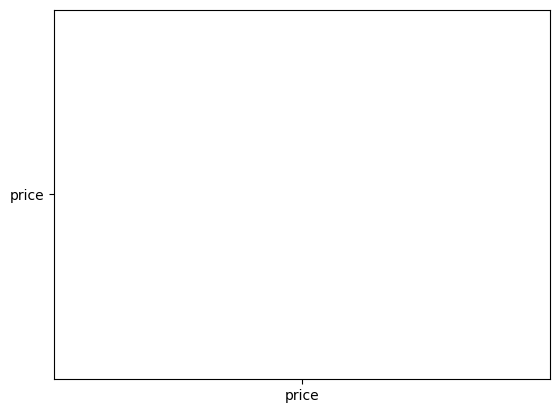

In [25]:
plt.bar("price",["price"])
plt.show()

In [234]:
X = df.drop(columns=["price","kitchen","postal_code","furnished","property_type", "locality","fireplace","province"])
y = df.price

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [236]:
X.columns

Index(['bedrooms', 'facades', 'terraceSurface', 'buildingState',
       'gardenSurface', 'pool', 'livingArea', 'surfaceOfThePlot',
       'house_index'],
      dtype='object')

In [75]:
categorical_feature_indices = ["property_type","province","locality"]

In [ ]:
model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, eval_metric="AUC" )
model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [238]:
#Make predictions
y_pred = model.predict(X_test)

#Evaluate Mean Square Root (MSE)
mse = root_mean_squared_error(y_test, y_pred)
print(model.score)
print(f"Root Mean Squared Error: {mse:.2f}")

<bound method CatBoostRegressor.score of <catboost.core.CatBoostRegressor object at 0x13c2a4cb0>>
Root Mean Squared Error: 353016.17


In [239]:
validation_pool = Pool(X_test, y_test)
metrics = model.eval_metrics(data=validation_pool, metrics=['R2', 'RMSE', 'MAE'])
print(metrics)

{'R2': [0.045413518163719635, 0.08146979150503353, 0.116379224954685, 0.1414536473718484, 0.16324454750672368, 0.18641104992799307, 0.20439014283726753, 0.2214891550823762, 0.23447862744337233, 0.24870043923016583, 0.25646355787581154, 0.2653743970242548, 0.27280283342808553, 0.28040135100022734, 0.2878119943994609, 0.2949764765441665, 0.30006870961341725, 0.30708880922954973, 0.31237511202550594, 0.3175725354537987, 0.32132204199433245, 0.32385171518681466, 0.32544572200384736, 0.32836254180403857, 0.3313723209083703, 0.33396422382165425, 0.3346364745950563, 0.33545516587870106, 0.33562102211737954, 0.33730543077243935, 0.3388659266581101, 0.34217298301281607, 0.34333777423167644, 0.34448592959229374, 0.3480688265937082, 0.34804880996091636, 0.3500786095267213, 0.35072114632243057, 0.3515379410312207, 0.3531570066397264, 0.3534977744013602, 0.3532016500745643, 0.35301548648364767, 0.35427415458620515, 0.35678038262428824, 0.35661109043708805, 0.3583731155894647, 0.3582284949633757, 0.

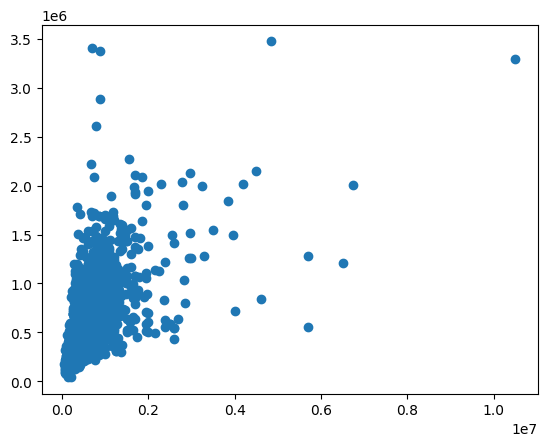

In [240]:
plt.scatter(y_test, y_pred)

plt.show()

In [241]:
df.price.max()

10500000.0

In [242]:
model = LinearRegression()
model.fit(X_train,y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [243]:
from sklearn.model_selection import train_test_split

# Split the data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Further split train+validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define and train the model
model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0)
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [244]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse}, Test R2: {r2}")


Test RMSE: 350874.0359958626, Test R2: 0.3999547148647532
